In [ ]:
# Exploring approaches to feature engineerin and class prediction on State Department Human Rights reports

## 1 : 

In [1006]:
import pandas as pd
import sqlite3 as sql

# 0 :  Define some NLP ceanin functions for later use

In [392]:
import re
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

stopWords.add('kill')
stopWords.add('killing')
stopWords.add('killings')

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams

def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    
    # Join list items using join()
    s = (" ".join(s)) 
    

    return(s) 


def clean_text(s):
    
    # Convert to lowercase
    s = s.lower()
    
    # Remove aposrphe
    s =s.replace("'", "")
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Repace all punctuatin with spaces
    s = re.sub(r'[^\w\s]',' ',s)

    # replace all double spaces, tabes, and returns
    s= re.sub(' +', ' ',s)
    
    s = s.replace('\n',' ')
    
    return(s)



def stem_word(text):
    
    stemmed = []
    stemmer = LancasterStemmer()
    
    for w in text:
        stemmed.append(stemmer.stem(w))
        
    return (stemmed)


def generate_ngrams(st, n):
    
   
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    #tokens = remove_stops(tokens)
    #tokens = stem_word(tokens)
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]




def word_grams(words, min=1, max=4):
    s = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1.0: Import 1a Africa Data

In [1008]:
# connect to MS_hackathon.db within the data/ directory, makes it if it doesn't exist
conn = sql.connect('../data/MS_hackathon.db')

In [1009]:
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('CIRI',), ('section1a_africa',), ('GapMinderData',)]


In [1010]:

c.execute('select * from section1a_africa;')
names = list(map(lambda x: x[0], c.description))
print(names)




['index', 'CountryName', 'Report']


In [1021]:
c.execute("SELECT * FROM section1a_africa;")
section_corpus = c.fetchall()
selection = pd.DataFrame(section_corpus)

selection.loc[:,2] = selection.loc[:,2].apply(lambda x: clean_text(x))


## 1.2: Clean 1a data

In [1012]:
#master_corpus = clean_text(master_corpus)
#master_corpus = remove_stops(master_corpus)


## 1.1: Vectorise 1a data

In [1013]:
from sklearn.feature_extraction.text import CountVectorizer

In [1044]:
section_corpus = convert(selection.loc[:,2])

#playing with n_gram range and max features to get a feel of what count vectoriser produces
count_vec = CountVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = count_vec.fit_transform([section_corpus])

count_vec_df = pd.DataFrame(matrix.toarray(), columns=count_vec.get_feature_names())
count_vec_df

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,46,40,60,54,62,48,36,54,106,43,...,87,37,55,37,37,55,37,57,55,38


In [1045]:
from sklearn.feature_extraction.text import TfidfVectorizer

section_corpus = selection.loc[:,2]


tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = tf_vectorizer.fit_transform(section_corpus)

tf_idf_df = pd.DataFrame(matrix.toarray(), columns=tf_vectorizer.get_feature_names())
tf_idf_df.head()

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,0.078227,0.083125,0.070762,0.072192,0.073652,0.076668,0.0,0.123221,0.144383,0.079821,...,0.336298,0.272944,0.079821,0.088395,0.136472,0.000000,0.000000,0.072192,0.073652,0.739324
1,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
2,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.268741,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.826397,0.297643,0.000000,0.000000,0.268741
4,0.101665,0.036010,0.122618,0.062548,0.127626,0.066426,0.0,0.053380,0.250192,0.034579,...,0.242811,0.177362,0.069159,0.038294,0.295604,0.109432,0.000000,0.093822,0.095720,0.053380


# 2.0 Trying out word clouds

In [296]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

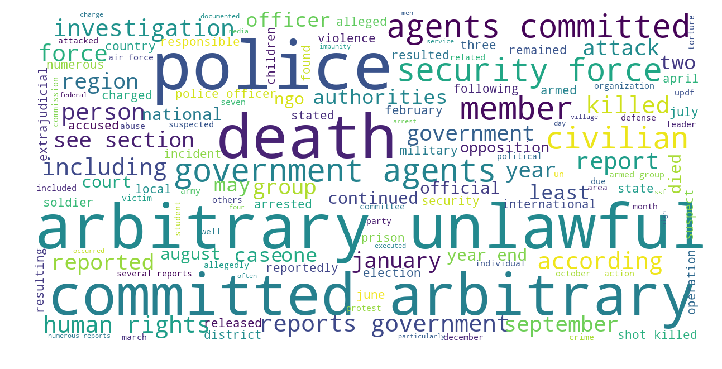

In [297]:


show_wordcloud(section_corpus)

# 3. 0: Part of Speach (POS) analysis on word 'reports'

## 3.1 Import 2018 all of africa reports

In [621]:
# import all text for Africa

text_folder = '../data/Custom_State_Dep_Reports/'

with open(text_folder+'2018_all_sections_africa.txt', 'r') as myfile:
  master_corpus = myfile.read()


In [739]:
# covert sentences into list items
text = master_corpus.replace('\n',' ') 
text =text.split('.')
text = [clean_text(i) for i in text]

# creat list of sentences with 'reports' mentioned
subs='reports'
res = [i for i in text if subs in i]
len(res)

1116

In [662]:
# download some additional nltk packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 3.2: Try analysing sentences with 'reports'

In [1046]:



def return_qualifiers(sentence2,scan_breadth):
    
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence2)
    POS_data   = nltk.pos_tag(tokens)
    
    
    # Determin words prior to keyword to sample
    keyword_position = tokens.index('reports')
    scan_breadth       = max(0, keyword_position-scan_breadth)
    words_prior      = POS_data[scan_breadth:keyword_position]

    #search through these words for verbs, adjectives and determiners which qualify keyword
    
    POS_before=['RB','EX','VBN','VBD','DT','JJ','NN','NNS','according'] # civil soc orgs; also see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_before:
        match = [i for i in words_prior if j in i]
        result.append(match)
    
    # an addional search for verbs after reports (reports indicated, reports confired)
    
    verb_list = ['VB','VBN','VBZ','VBD']
    
    for verb in verb_list:   
        try:
            if POS_data[keyword_position+1][1] == verb:
                result.append(POS_data[keyword_position+1])
        except:
            pass
  

    return(result)

#VBD,VB
#print(Before_report)
#print(POS_data)


def return_details(sentence,scan_breadth):
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence)
    POS_data   = nltk.pos_tag(tokens)
    
    # Determin words after keyword to sample
    #keyword_position = tokens.index('reports')
    #scan_breadth = min(len(POS_data),keyword_position+scan_breadth)
    #words_after = POS_data[keyword_position+1:scan_breadth]

    # scan forwards for nouns NN, NNS, and Adjectives JJ and verbs VB VBD to describe report content
    POS_after=['NN','NNS','JJ','VBD','VBG'] # see see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_after:
        match = [i for i in POS_data if j in i]
        result.append(match)
    return(result)

print(return_qualifiers(res[1002],4))

print(return_details(res[1002],15))



[[], [], [], [('received', 'VBD')], [], [('regular', 'JJ')], [], [], []]
[[('expert', 'NN'), ('situation', 'NN'), ('sudan', 'NN'), ('s', 'NN'), ('section', 'NN'), ('rape', 'NN'), ('gender', 'NN'), ('violence', 'NN'), ('see', 'NN'), ('section', 'NN')], [('rights', 'NNS'), ('rights', 'NNS'), ('reports', 'NNS'), ('incidents', 'NNS')], [('international', 'JJ'), ('human', 'JJ'), ('unamid', 'JJ'), ('human', 'JJ'), ('regular', 'JJ'), ('sexual', 'JJ')], [('reported', 'VBD'), ('received', 'VBD')], []]


# 4.0 Use SVM to classify text

## 4.1 Use SVM to classify reports vs no reports

Using some labeled data I put together manually, this classfies sentences with 'reports' in the sentence as positive or negaitve

### 4.1.1 Import labled training data and all of africa 2018 text

In [1047]:

training_df=pd.read_csv('../data/NLP_training_set.csv')
training_df = training_df.drop(columns=['Unnamed: 0'])

training_df['Basic_Class']=training_df['Class']

training_df['Basic_Class'].replace(1,0,inplace=True)
training_df['Basic_Class'].replace(2,1,inplace=True)
training_df['Basic_Class'].replace(3,1,inplace=True)


### 4.1.2 Apply SVM classifier

In [797]:
from sklearn.model_selection import train_test_split


X = training_df['String']
y = training_df['Basic_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [991]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

### 4.1.3 Evaluate SVM classifier

In [795]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.9373134328358209
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       164
           1       0.93      0.95      0.94       171

   micro avg       0.94      0.94      0.94       335
   macro avg       0.94      0.94      0.94       335
weighted avg       0.94      0.94      0.94       335

[[151  13]
 [  8 163]]


## 4.2 Use SVM to predict report section membership (hence type of offence)

now that Marie has pacred the africa section, I can look at how SVM performs on recognising types of transgessions

In [848]:
df_all_africa = pd.read_csv('../data/Custom_State_Dep_Reports/2018_all_sections_africa_PARCED.csv')

In [1049]:
df_train=pd.DataFrame(columns=['text','label'])

for i in range(len(df_all_africa.columns)-3): 
    df_extract = pd.DataFrame(columns=['text','label'])
    df_all_africa.iloc[:,i+3] = df_all_africa.iloc[:,i+3].astype(str)
    df_extract['text']=' '.join(df_all_africa.iloc[:,i+3]).replace('\n',' ').split('.')
    df_extract['label'] = df_all_africa.columns[i+3]
    df_train= df_train.append(df_extract)


In [1050]:
X = df_train['text']
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [1051]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

### 4.2.1: Evaluate model

In [1052]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.6923897107823537
              precision    recall  f1-score   support

  Section_1a       0.44      0.19      0.27       125
  Section_1b       0.66      0.32      0.43        59
  Section_1c       0.70      0.72      0.71       657
  Section_1d       0.68      0.62      0.65       678
  Section_1e       0.67      0.66      0.66       530
  Section_1f       0.69      0.27      0.39        93
  Section_1g       0.49      0.23      0.31       139
  Section_2a       0.72      0.81      0.76       512
  Section_2b       0.68      0.40      0.50       175
  Section_2c       0.89      0.63      0.74        51
  Section_2d       0.77      0.74      0.76       455
   Section_3       0.69      0.75      0.72       394
   Section_4       0.74      0.67      0.70       263
   Section_5       0.71      0.43      0.54       187
   Section_6       0.65      0.90      0.75      1668
  Section_7a       0.80      0.81      0.81       432
  Section_7b       0.65      0.28      0.39       188

Performs better on some cataories than others, this is without text cleaning or parameter tuning, so it feels promissing

####  testing on classifying sections of Amnesty International

Women

In [899]:
test = "Reports of domestic violence increased; immediate protection orders had been issued by 1 June. In August, Judge Fildeze Hafizi was shot and killed in her car by her former husband. She had been granted a protection order in 2015 after he had beaten her. He was convicted and imprisoned in April 2016, but released in early 2017 under a general amnesty."
test = test.split('.')
y_pred = sgd.predict(test)
y_pred

In [910]:
test2 = 'Physical attacks against investigative journalists were perpetrated by organized criminals, or owners of private companies. In March, journalist Elvi Fundo was beaten in the capital, Tirana, by assailants believed to be associated with organized crime. In June, TV channel owner Erven Hyseni was shot dead in Vlora, along with a government official. In July, journalists claimed that defamation proceedings brought against two media outlets by High Court Judge Gjin Gjoni and his wife, businesswoman Elona Caushi, aimed to intimidate investigative journalists and encourage self-censorship.'
test2 = test2.split('.')
y_pred = sgd.predict(test2)
y_pred

In [914]:
test3 = 'No measures were taken to locate the body of Remzi Hoxha, a Macedonian Albanian who was forcibly disappeared by National Intelligence Service officials in 1995. No progress was reported towards the exhumation of the remains of around 6,000 people who had disappeared between 1945 and 1991.'
test3 = test3.split('.')
y_pred = sgd.predict(test3)
y_pred

In [918]:
test4 = 'Measures to ensure judicial independence were partially implemented. In June, two judicial associations appealed to the Constitutional Court against a vetting law, which sought to ensure judges’ and prosecutors’ independence from organized crime.'
test4 = test4.split('.')
y_pred = sgd.predict(test4)
y_pred

# 4. 3 Using SVM to predict CIRI scores

In [1078]:
data_df = pd.read_csv('../data/Custom_State_Dep_Reports/CIRI_Text_1999_2009.csv')
data_df['POLPRIS'].unique()


array([  2.,   0.,   1.,  nan, -77., -66.])

In [996]:
data_df.columns

Index(['Unnamed: 0', 'Country', 'Text', 'Unnamed: 0.1', 'CTRY', 'YEAR', 'CIRI',
       'COW', 'POLITY', 'UNCTRY', 'UNREG', 'UNSUBREG', 'PHYSINT', 'DISAP',
       'KILL', 'POLPRIS', 'TORT', 'OLD_EMPINX', 'NEW_EMPINX', 'ASSN', 'FORMOV',
       'DOMMOV', 'OLD_MOVE', 'SPEECH', 'ELECSD', 'OLD_RELFRE', 'NEW_RELFRE',
       'WORKER', 'WECON', 'WOPOL', 'WOSOC', 'INJUD'],
      dtype='object')

In [1072]:
sgd = Pipeline([('vect', CountVectorizer(stop_words='english',ngram_range=(1,3))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),
               ])

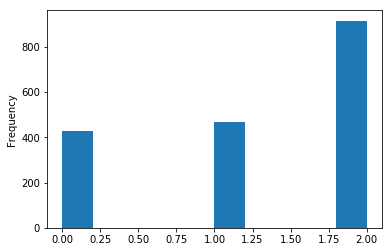

In [1079]:
CIRI_Label = 'POLPRIS'


test_df = data_df[['Text',CIRI_Label]].dropna()
test_df = test_df[test_df[CIRI_Label].isin([  0.,   1.,   2.])]

test_df[CIRI_Label].plot.hist()
X = test_df['Text'].apply(lambda x: clean_text(x))
y = test_df[CIRI_Label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [1080]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

In [1075]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.7908256880733945
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       122
         1.0       0.79      0.78      0.79       268
         2.0       0.85      0.78      0.81       155

   micro avg       0.79      0.79      0.79       545
   macro avg       0.79      0.79      0.79       545
weighted avg       0.79      0.79      0.79       545

[[100  22   0]
 [ 37 210  21]
 [  0  34 121]]


In [957]:
# Max itter 30
    #no stop words = 73.2
    #with stop words = 77.8
        # with ngram range of 1 to 3 : 79.3
# Max itter 60    
    #with stop words = 77.8
        # with ngram range of 1 to 3 : 79.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 168
Data columns (total 2 columns):
Text      139 non-null object
WORKER    139 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB
